# Twitter data analysis project
## Data exploration

The purpose of this notebook is to explore the data to extract any meaningful information we can share with the stakeholders.<br>
For the part of the data exploration, we decide to provide some information about the shape of the data we extracted from the JSON file named *global_twitter_data.json*. Those information are:
* shape of the data frame
* distribution of the languages (number of occurence of the tweets languages)
* the most used hashtags
* the general opinion of tweetos
* whether we can trust or not the information conveyed by the tweets
* the most used words

In [1]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics, string, re, random

sys.path.append(os.path.abspath(os.path.join('../')))

# Import the modules
from clean_tweets_dataframe import Clean_Tweets

# Import the data set
df = pd.read_csv("../data/processed_tweet_data.csv")

In [2]:
# Look at the information about the data set
print(df.shape)
df.info()

(22000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          22000 non-null  object 
 1   source              22000 non-null  object 
 2   original_text       22000 non-null  object 
 3   clean_text          22000 non-null  object 
 4   polarity            22000 non-null  float64
 5   subjectivity        22000 non-null  float64
 6   sentiment           22000 non-null  object 
 7   lang                22000 non-null  object 
 8   favorite_count      22000 non-null  int64  
 9   retweet_count       22000 non-null  int64  
 10  original_author     22000 non-null  object 
 11  followers_count     22000 non-null  int64  
 12  friends_count       22000 non-null  int64  
 13  possibly_sensitive  6191 non-null   object 
 14  hashtags            22000 non-null  object 
 15  user_mentions       22000 non-null  objec

We have $22000$ tweets in our data set and $17$ features.

In [3]:
cleanTweet = df[["clean_text","polarity"]]

In [4]:
# Get the text category (positive, negative, neutral)
def text_category(polarity):
    """
    Description:
    ------------
    Function to return sentiment carried out by a tweet (using it's polarity)
    """
    if polarity < 0:
        return('negative')
    elif polarity >0:
        return('positive')
    else:
        return('neutral')

# Plot the repartition of the languages
def plot_bar(df,col:str):
    """
    Description:
    ------------
    Draw bar plot based on the column 'col' in the dataframe 'df'
    """
    plt.bar(df[col].value_counts().index,df[col].value_counts())
    plt.show()

def plot_pie(df,col:str):
    """
    Description:
    ------------
    Draw a pie plot based on the column 'col' in the dataframe 'df'
    """
    plt.pie(df[col].value_counts(),labels=df[col].value_counts().index)
    plt.show()

# Extract elements
def extract_el(df,col,num_el=5):
    """
    Description:
    ------------
    Extract the top 'num_el' elements
    """
    res = pd.DataFrame(df[col].value_counts()[:num_el])
    return res

          score
positive  10193
negative   5924
neutral    5883


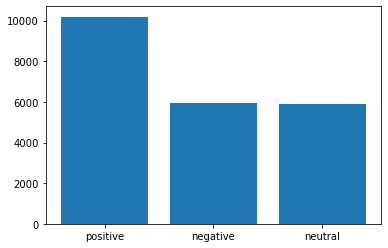

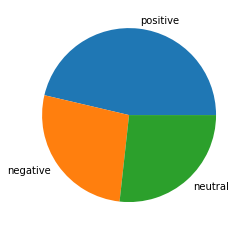

In [5]:
# Compute the text category and plot it
cleanTweet['score'] = cleanTweet['polarity'].apply(text_category)
print(pd.DataFrame(cleanTweet['score'].value_counts()))
plot_bar(cleanTweet,'score')
plot_pie(cleanTweet,'score')

In [6]:
# Remove rows where polarity = 0
cleanTweet = cleanTweet[cleanTweet["polarity"]!=0]
cleanTweet["score"].value_counts()

positive    10193
negative     5924
Name: score, dtype: int64

In [7]:
# Construct scoremap column
def mapscore(score):
    if score=='positive':
        return 1
    else: return 0

cleanTweet['scoremap']=list(map(mapscore,cleanTweet['score']))
cleanTweet['scoremap'].describe()

count    16117.000000
mean         0.632438
std          0.482156
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: scoremap, dtype: float64

In [8]:
# Extract the top 10 Original author
extract_el(df,'original_author',10)

,original_author
TrumpThuan,116
CGMeifangZhang,65
AarianNewsX,59
Lin73324756,48
Bin20211001,46
YangChenbin,45
Alex28807650,44
SoizaDavid,42
fchaumac_chau,41
hephaistos_ai,39


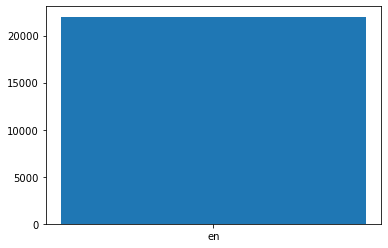

In [9]:
plot_bar(df,'lang')

In [10]:
# Clean the tweets
dfObj = Clean_Tweets(df)
dfObj.drop_duplicate()
dfObj.drop_unwanted_column()
dfObj.convert_to_datetime('created_at')
dfObj.convert_to_numbers()
dfClean = dfObj.remove_non_english_tweets()

Automation in Action...!!!


In [11]:
dfClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22000 entries, 0 to 21999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          22000 non-null  datetime64[ns, UTC]
 1   source              22000 non-null  object             
 2   original_text       22000 non-null  object             
 3   clean_text          22000 non-null  object             
 4   polarity            22000 non-null  float64            
 5   subjectivity        22000 non-null  float64            
 6   sentiment           22000 non-null  object             
 7   lang                22000 non-null  object             
 8   favorite_count      22000 non-null  int64              
 9   retweet_count       22000 non-null  int64              
 10  original_author     22000 non-null  object             
 11  followers_count     22000 non-null  int64              
 12  friends_count       22000 non-nu

In [12]:
#Method to find hashtags from tweets
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [15]:
# update Hashtage column with hashtages extracted from Orignal_text columon
dfClean['hashtags'] = dfClean.original_text.apply(find_hashtags)

# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = dfClean.loc[
                       dfClean.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

#create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

<AxesSubplot:>

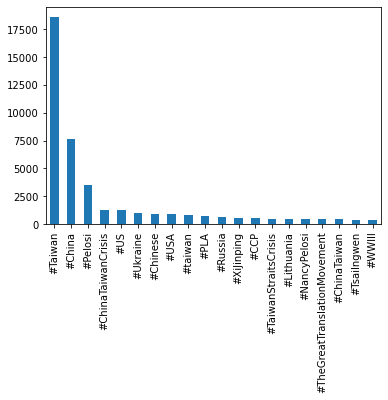

In [18]:
flattened_hashtags_df['hashtag'].value_counts()[:20].plot(kind='bar')

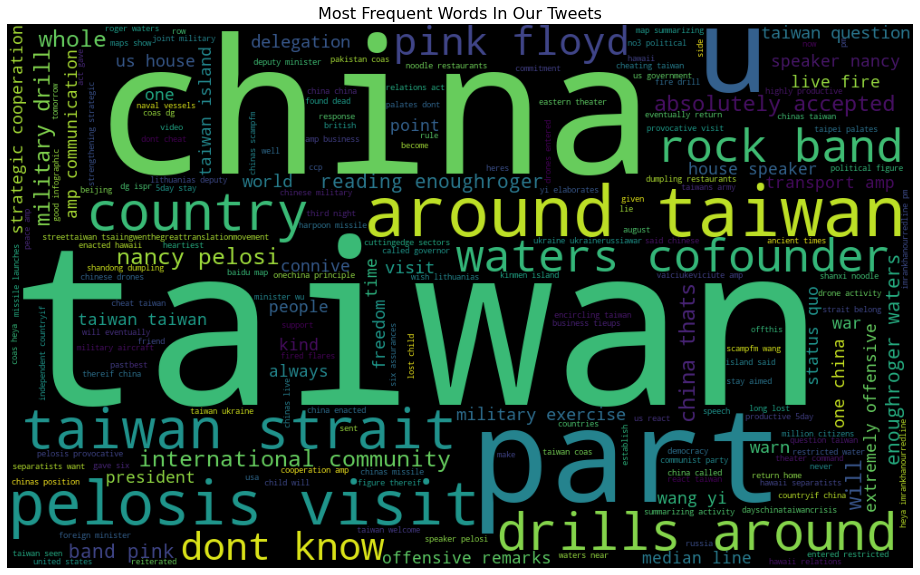

In [19]:
# Draw the word cloud
tweets = pd.DataFrame(columns=['text'])
tweets['text'] = dfClean['clean_text']

tweets['text']= tweets['text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
plt.figure(figsize=(20, 10))
wdcloud = WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(tweets.text.values))

# Create function to generate the blue colour for the Word CLoud

def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(wdcloud.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

<a website href="https://www.freepnglogos.com/pics/logo-twitter-png" title="Image from freepnglogos.com"><img src="https://www.freepnglogos.com/uploads/twitter-logo-png/twitter-logo-white-circle-png-images-23.png" width="200" alt="twitter logo white circle png images" /></a>